# Epiblast to neural epithelial to radial glia transition

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()

/datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
# # ## continue Scanpy in python
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
readRDS = robjects.r['readRDS']

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

## Read human CS7 gastrual data

In [3]:
df=readRDS("/datb/home/wanglab13/PythonScripts/Cell_response/annot_umap.rds")
gstrula_mtx=readRDS("/datb/home/wanglab13/PythonScripts/Cell_response/expression_values.rds")
adata_gastrula=sc.AnnData(X=gstrula_mtx,
                         obs=df)
adata_gastrula.obs.set_index('cell_name',inplace=True,drop=True)
adata_gastrula.obs.index=adata_gastrula.obs.index.astype('str')

In [4]:
adata_gastrula.obsm['X_umap']=np.array(adata_gastrula.obs[['X0','X1']])

In [5]:
adata_gastrula

AnnData object with n_obs × n_vars = 1195 × 57490 
    obs: 'X', 'X0', 'X1', 'cluster_id', 'sub_cluster'
    obsm: 'X_umap'

In [6]:
map_coarse = {}
for c in adata_gastrula.obs['cluster_id'].cat.categories:
    map_coarse[c]='Gastrula_'+c
adata_gastrula.obs['cluster_id_v1']=adata_gastrula.obs['cluster_id']
adata_gastrula.obs.replace({'cluster_id_v1':map_coarse},inplace=True)

## Merge CS7 epiblast and PCW345 NE, RG

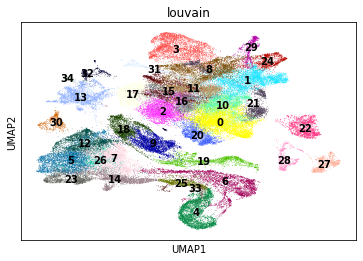

Trying to set attribute `.obs` of view, making a copy.


In [7]:
adata_w345 = sc.read("/newdatb/home/wanglab13/scratch/wholebrain/results/agg_HE-5-4W/scanpy/write/wholebody_w3-5_V4.h5ad")

sc.pl.umap(adata_w345,color='louvain',legend_loc='on data')

adata_w345_test = adata_w345.copy()
adata_w345_test.X = adata_w345.raw.X

## only select Ne and RG clusters
adata_w345_sub = adata_w345_test[adata_w345_test.obs['louvain'].isin(['12','26','5','7','23','14'])]
adata_w345_sub

map_coarse = {}
for c in adata_w345_sub.obs['louvain'].cat.categories:
    if c in ['12']:
        map_coarse[c]='NE'
    if c in ['26','5','7','23','14']:
        map_coarse[c]='RG'
adata_w345_sub.obs['clusters']=adata_w345_sub.obs['louvain']
adata_w345_sub.obs.replace({'clusters':map_coarse},inplace=True)

adata_w345_sub.uns['clusters_colors']=['#4daf4a','#e41a1c','#377eb8']

... storing 'clusters' as categorical
... storing 'cluster_id_v1' as categorical


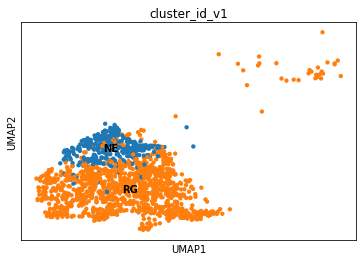

In [8]:
## subsampling NE and RG cells of 10% due to the small amount of epiblast cells
adata_w345_sub.obs['cluster_id_v1']=adata_w345_sub.obs['clusters']
sc.pp.subsample(adata_w345_sub,fraction=0.1)
sc.pl.umap(adata_w345_sub,color='cluster_id_v1',legend_loc='on data')

... storing 'cluster_id_v1' as categorical


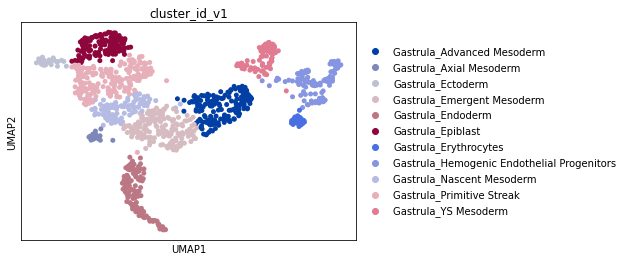

In [9]:
sc.pl.umap(adata_gastrula,color='cluster_id_v1')

In [10]:
adata_gastrula_sub = adata_gastrula[adata_gastrula.obs['cluster_id_v1'].isin(['Gastrula_Epiblast'])]

adata_w345_sub_v1=sc.AnnData(X=adata_w345_sub.X.A,
                            obs=adata_w345_sub.obs,
                            var=adata_w345_sub.var,
                            obsm=adata_w345_sub.obsm,
                            uns=adata_w345_sub.uns)

adata_eb_ne_rg = adata_gastrula_sub.concatenate(adata_w345_sub_v1)

In [11]:
adata_eb_ne_rg.obs['n_counts'] = adata_eb_ne_rg.X.sum(axis=1)
sc.pp.filter_cells(adata_eb_ne_rg, min_genes=200)
sc.pp.filter_genes(adata_eb_ne_rg, min_cells=3)

sc.pp.normalize_total(adata_eb_ne_rg)

sc.pp.log1p(adata_eb_ne_rg)

sc.pp.highly_variable_genes(adata_eb_ne_rg, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.tl.pca(adata_eb_ne_rg, svd_solver='arpack',use_highly_variable=True)

pca = adata_eb_ne_rg.obsm['X_pca']

timepoints = adata_eb_ne_rg.obs['batch']

filtered out 2715 genes that are detected in less than 3 cells
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00.35)


## correct batch effects using scran fastmnn function

In [12]:
%%R -i pca -i timepoints -o correct
require(scran)
require(irlba)
require(BiocParallel)
rownames(pca) = names(timepoints)
pc_list = lapply(unique(timepoints), function(tp){
sub_pc = pca[timepoints == tp, , drop = FALSE]
return(sub_pc)
})
names(pc_list) = unique(timepoints)
correct = do.call(fastMNN, c(pc_list, "pc.input" = TRUE, BPPARAM = SerialParam()))$corrected
correct = correct

In [13]:
adata_eb_ne_rg.obsm['X_pca'] = correct

computing neighbors
    using 'X_pca' with n_pcs = 40


/datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/umap/umap_.py:328: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': Cannot determine Numba type of <class 'function'>

File "../../../../../datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/umap/umap_.py", line 446:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or 

    finished (0:00:09.46) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 40
    finished (0:00:06.27) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.07) --> found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
drawing single-cell graph using layout "fa"


... storing 'cluster_id' as categorical
... storing 'cluster_id_v1' as categorical
... storing 'clusters' as categorical
... storing 'sub_cluster' as categorical
... storing 'week_stage' as categorical


    finished (0:00:07.09) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.9740451  0.9619482  0.95165414 0.9492677  0.94172376
     0.93664235 0.93088216 0.9245601  0.92183316 0.9182739  0.9140481
     0.90276617 0.8965064  0.89155954]
    finished (0:00:00.08) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)


... storing 'feature_types-1-0-1' as categorical


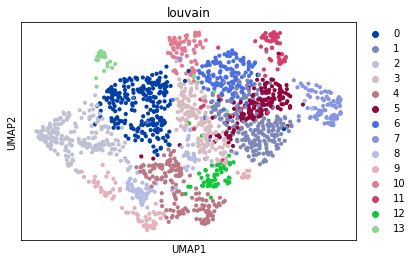

In [14]:
## used harmony batch correction
sc.pp.neighbors(adata_eb_ne_rg, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_eb_ne_rg)
sc.tl.louvain(adata_eb_ne_rg)
sc.tl.draw_graph(adata_eb_ne_rg)
sc.tl.diffmap(adata_eb_ne_rg)
sc.pl.umap(adata_eb_ne_rg, color=['louvain'])

In [15]:
adata_eb_ne_rg.rename_categories('batch', ['Human gastrula','Human PCW345'])

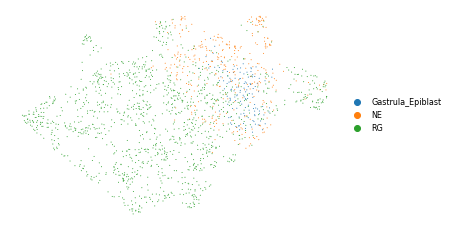

In [16]:
sc.pl.umap(adata_eb_ne_rg, color=['cluster_id_v1'],size=4,frameon=False,legend_fontsize=8,title='')

running PAGA
    finished (0:00:00.02) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
--> added 'pos', the PAGA positions (adata.uns['paga'])


/datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):


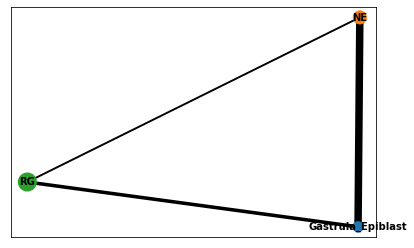

--> added 'pos', the PAGA positions (adata.uns['paga'])


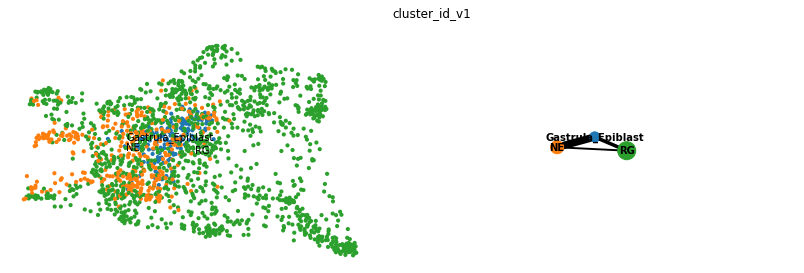

In [17]:
# Get PAGA graph
sc.tl.paga(adata_eb_ne_rg, groups='cluster_id_v1')
sc.pl.paga(adata_eb_ne_rg, threshold=0.01, edge_width_scale=1)

sc.pl.paga_compare(adata_eb_ne_rg, threshold=0.01, edge_width_scale=1,                  
                   legend_fontsize=10, legend_fontweight='medium')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         0.9740451  0.9619482  0.95165414 0.9492677  0.94172376
     0.93664235 0.93088216 0.9245601  0.92183316 0.9182739  0.9140481
     0.90276617 0.8965064  0.89155954]
    finished (0:00:00.08) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.00) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


(-1944.823386397595, 2202.071247141376, -2681.395919618646, 2734.196646464261)

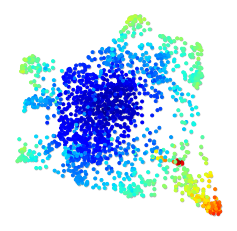

In [18]:
import matplotlib.pyplot as plt
# Calculate dpt pseudotime, starting from the Gastrula_Epiblast cluster
adata_eb_ne_rg.uns['iroot'] = np.flatnonzero(adata_eb_ne_rg.obs['cluster_id_v1']  == 'Gastrula_Epiblast')[0]
sc.tl.diffmap(adata_eb_ne_rg)
sc.tl.dpt(adata_eb_ne_rg)

PMflag = adata_eb_ne_rg.obs['cluster_id_v1'].isin(['Gastrula_Epiblast',  'NE', 'RG'])
fig,ax =plt.subplots(figsize=(4,4))
ax.scatter(adata_eb_ne_rg.obsm['X_draw_graph_fa'][:,0], adata_eb_ne_rg.obsm['X_draw_graph_fa'][:,1], c=[.7,.7,.7], s=8)
ax.scatter(adata_eb_ne_rg.obsm['X_draw_graph_fa'][:,0][PMflag], adata_eb_ne_rg.obsm['X_draw_graph_fa'][:,1][PMflag], 
           c=adata_eb_ne_rg.obs['dpt_pseudotime'][PMflag], cmap='jet', s=8)
ax.set_xticks([]); ax.set_yticks([]);
ax.set_xlabel(''); ax.set_ylabel(''); ax.set_title('')
ax.axis('off')

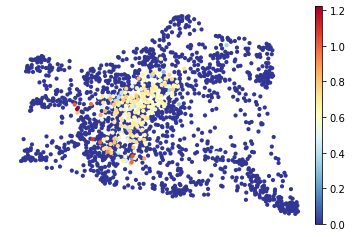

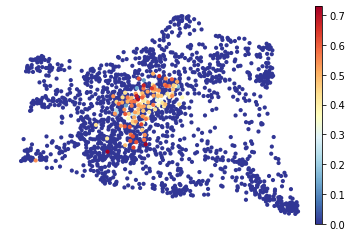

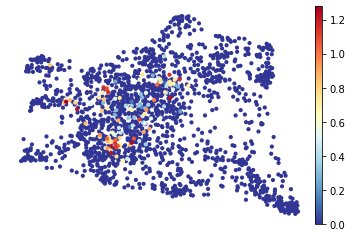

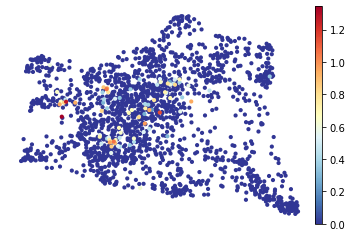

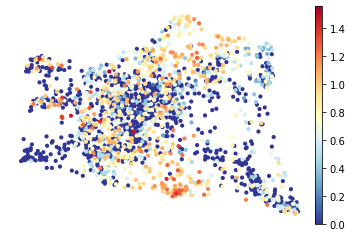

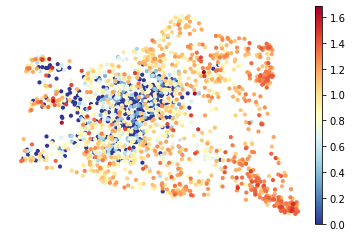

In [19]:
genes=['POU5F1','CDH1','SIX3','LHX2','PAX6','NES']
for gene in genes:
    fig,ax=plt.subplots()
    sc.pl.draw_graph(adata_eb_ne_rg,color=gene,cmap='RdYlBu_r',legend_loc='right margin',ax=ax,legend_fontsize=8,frameon=False,title='',show=False)
#     plt.savefig('./Paper_figures/Epiblast_NE_RG_{}.pdf'.format(gene),dpi=300, format='pdf')

/datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/scanpy/plotting/_tools/paga.py:1015: UserWarning: FixedFormatter should only be used together with FixedLocator
  groups_axis.set_yticklabels(['', xlabel, ''], fontsize=ytick_fontsize)
/datb/home/wanglab13/anaconda3/envs/r2/lib/python3.6/site-packages/scanpy/plotting/_tools/paga.py:1048: UserWarning: FixedFormatter should only be used together with FixedLocator
  fontsize=ytick_fontsize)


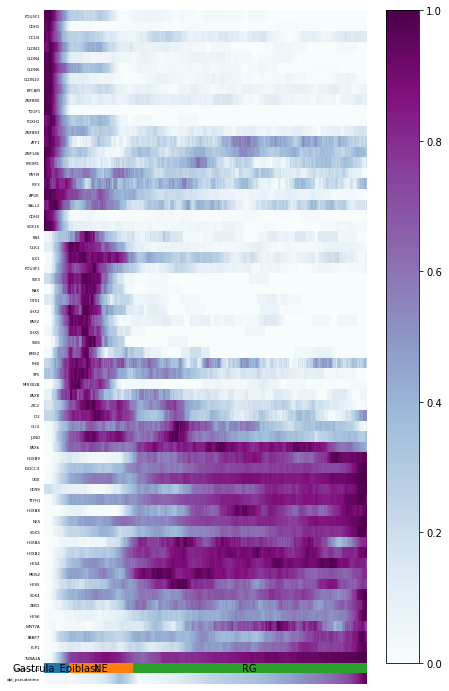

In [20]:
epiblast_genes=['POU5F1','CDH1','OCLN','CLDN3','CLDN4','CLDN6','CLDN10','EPCAM','ZNF880','TDGF1',
                'FOXH1','ZNF883','ATF1','ZNF146','PROM1','MYH9','IRF3','APOE','SALL2','CDH3', 'SOX15']
ne_genes=['EN1','DLK1', 'LIX1','POU3F1','SIX3', 'RAX','OTX1','LHX2','PAX2','LHX5', 'SIX6','EMX2','PHB','SP5',
          'MIR302B','PAX8','ZIC2','ID2','GLI3','JUND', 'PAX6']
rg_genes=['HOXB9', 'IGDCC3', 'CKB', 'CD99', 'TTYH1', 'HOXB8', 'NES', 'SOX3', 'HOXB4', 'HOXB2', 'HES4', 
             'MEIS2', 'HES5','SOX4', 'ZEB1','HES6', 'WNT7A', 'FABP7',  'PLP1', 'TUBA1A']
markers=epiblast_genes+ne_genes+rg_genes
traj_nodes = ['Gastrula_Epiblast',  'NE', 'RG']
fig,ax=plt.subplots(figsize=(8,12))
ax = sc.pl.paga_path(adata_eb_ne_rg, nodes=traj_nodes, keys=markers, use_raw=True, annotations=['dpt_pseudotime'],
                     color_map='BuPu', color_maps_annotations={'dpt_pseudotime': 'BuPu'}, palette_groups=None, 
                     n_avg=100, groups_key=None, xlim=[None, None], title=None, left_margin=None, ytick_fontsize=4,
                     title_fontsize=None, show_node_names=True, show_yticks=True, show_colorbar=True, 
                     legend_fontsize=1, legend_fontweight=None, normalize_to_zero_one=True, as_heatmap=True, 
                     return_data=True, show=False, ax=None)
# plt.savefig("/datb/home/wanglab13/PythonScripts/Paper_figures/Epiblast_NE_RG_heatmap_v2.pdf", dpi=300, format='pdf', bbox_inches='tight')

## For the signal pathway genes, analyze the dynamc expression changes during the epiblast to RG differentiation

In [21]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import numpy

data=adata_eb_ne_rg.X

data=pd.DataFrame(data)

data.index=adata_eb_ne_rg.obs_names
data.columns=adata_eb_ne_rg.var_names

data['pseudotime']=adata_eb_ne_rg.obs['dpt_pseudotime']

data.shape

(1723, 15174)

## Tight Junction 

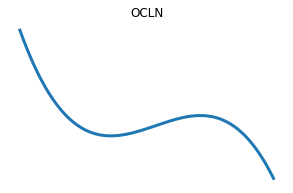

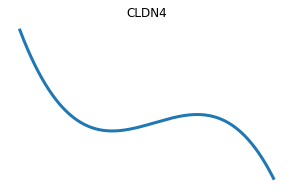

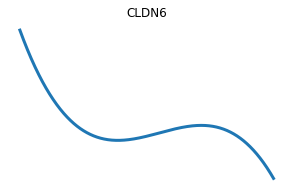

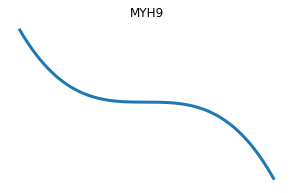

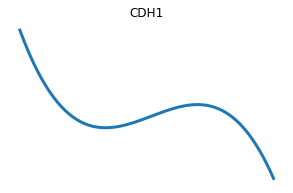

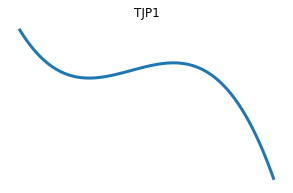

In [22]:
tj_genes=['OCLN','CLDN4','CLDN6','MYH9','CDH1','TJP1']
for gene in tj_genes:
    x=data['pseudotime']
    y=data[gene]
    y=y[numpy.argsort(x)]
    x=sorted(x)
    spl = UnivariateSpline(x, y,k=3)
    xs = np.linspace(0, 1, 1000)
    fig,ax=plt.subplots(figsize=(5,3))
    ax.plot(xs, spl(xs), lw=3)
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(False)
    plt.title(gene)
#     fig.savefig("/datb/home/wanglab13/PythonScripts/Paper_figures/Epiblast_NE_RG_signal_pathways/TJ_{}_dyn_expr_v1.pdf".format(gene),dpi=300, format='pdf', bbox_inches='tight', transparent=True)

<AxesSubplot:title={'center':'Mean'}, xlabel='Clusters'>

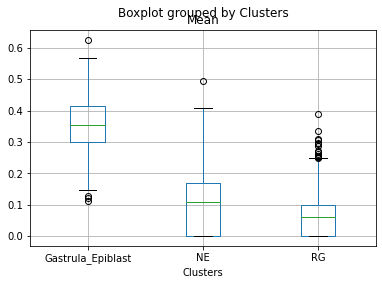

In [23]:
tj_genes=['OCLN','CLDN4','CLDN6','MYH9','CDH1','TJP1']

df=pd.DataFrame(np.array(adata_eb_ne_rg[:,tj_genes].X.mean(axis=1)))

df['cluster']=adata_eb_ne_rg.obs['cluster_id_v1'].values

df.columns=['Mean','Clusters']

df.boxplot('Mean',by='Clusters')
# plt.savefig("/datb/home/wanglab13/PythonScripts/Cell_response/Paper_figures/Boxplot_tj.pdf", dpi=300, format='pdf', bbox_inches='tight')

## epithelial to messenchyal transition (EMT)

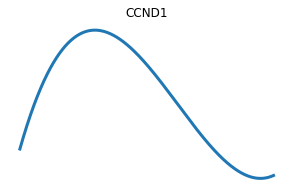

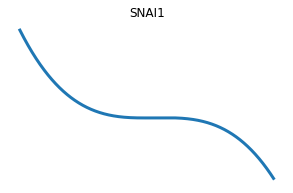

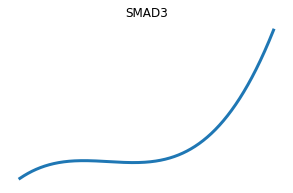

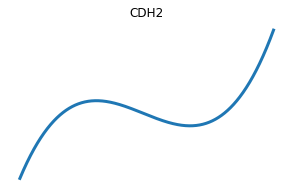

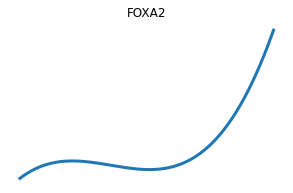

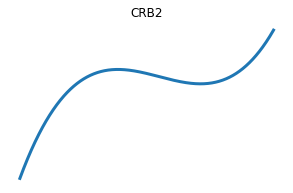

In [30]:
emt_genes=['CCND1','SNAI1','SMAD3','CDH2','FOXA2','CRB2']
for gene in emt_genes:
    x=data['pseudotime']
    y=data[gene]
    y=y[numpy.argsort(x)]
    x=sorted(x)
    spl = UnivariateSpline(x, y,k=3)
    xs = np.linspace(0, 1, 1000)
    fig,ax=plt.subplots(figsize=(5,3))
    ax.plot(xs, spl(xs), lw=3)
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(False)
    plt.title(gene)

<AxesSubplot:title={'center':'Mean'}, xlabel='Clusters'>

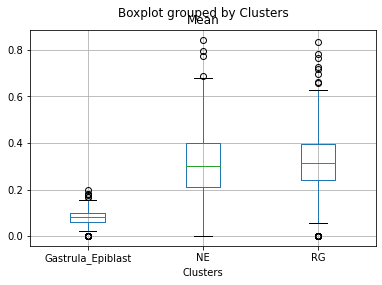

In [31]:
emt_genes=['CCND1','SNAI1','SMAD3','CDH2','FOXA2','CRB2']

df=pd.DataFrame(np.array(adata_eb_ne_rg[:,emt_genes].X.mean(axis=1)))

df['cluster']=adata_eb_ne_rg.obs['cluster_id_v1'].values

df.columns=['Mean','Clusters']

df.boxplot('Mean',by='Clusters')
# plt.savefig("/datb/home/wanglab13/PythonScripts/Cell_response/Paper_figures/Boxplot_emt.pdf", dpi=300, format='pdf', bbox_inches='tight')

## mTOR signal pathway

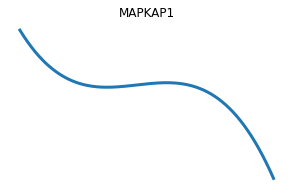

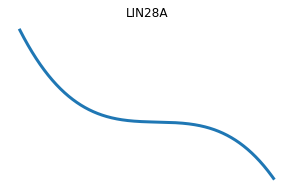

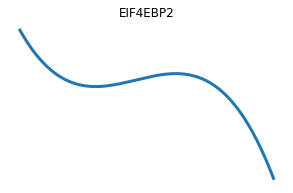

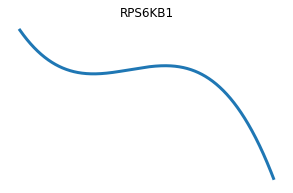

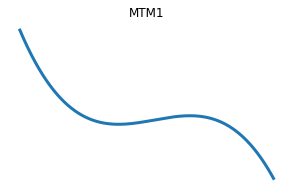

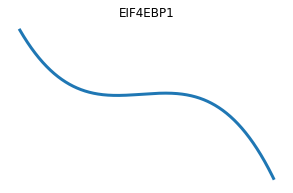

In [32]:
mtor_genes=['MAPKAP1','LIN28A','EIF4EBP2','RPS6KB1','MTM1','EIF4EBP1']
for gene in mtor_genes:
    x=data['pseudotime']
    y=data[gene]
    y=y[numpy.argsort(x)]
    x=sorted(x)
    spl = UnivariateSpline(x, y,k=3)
    xs = np.linspace(0, 1, 1000)
    fig,ax=plt.subplots(figsize=(5,3))
    ax.plot(xs, spl(xs), lw=3)
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(False)
    plt.title(gene)

<AxesSubplot:title={'center':'Mean'}, xlabel='Clusters'>

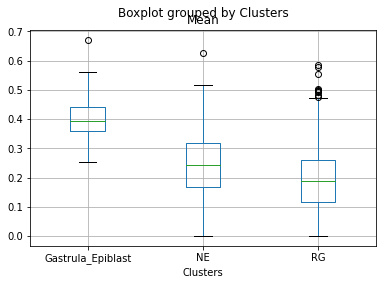

In [33]:
mtor_genes=['MAPKAP1','LIN28A','EIF4EBP2','RPS6KB1','MTM1','EIF4EBP1']

df=pd.DataFrame(np.array(adata_eb_ne_rg[:,mtor_genes].X.mean(axis=1)))

df['cluster']=adata_eb_ne_rg.obs['cluster_id_v1'].values

df.columns=['Mean','Clusters']

df.boxplot('Mean',by='Clusters')
# plt.savefig("/datb/home/wanglab13/PythonScripts/Cell_response/Paper_figures/Boxplot_mtor.pdf", dpi=300, format='pdf', bbox_inches='tight')

## NOTCH signal pathway

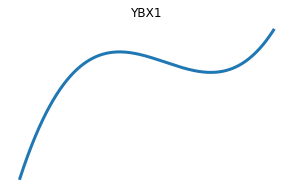

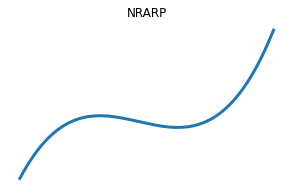

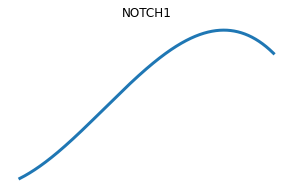

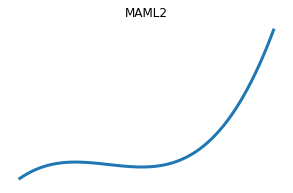

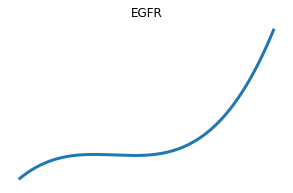

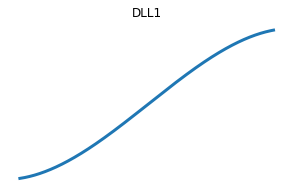

In [34]:
notch_genes=['YBX1','NRARP','NOTCH1','MAML2','EGFR','DLL1']
for gene in notch_genes:
    x=data['pseudotime']
    y=data[gene]
    y=y[numpy.argsort(x)]
    x=sorted(x)
    spl = UnivariateSpline(x, y,k=3)
    xs = np.linspace(0, 1, 1000)
    fig,ax=plt.subplots(figsize=(5,3))
    ax.plot(xs, spl(xs), lw=3)
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(False)
    plt.title(gene)

<AxesSubplot:title={'center':'Mean'}, xlabel='Clusters'>

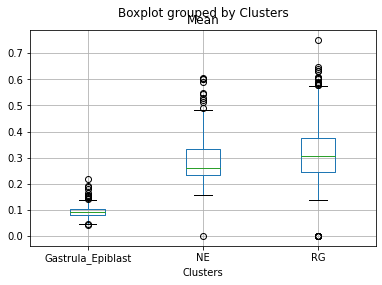

In [35]:
notch_genes=['YBX1','NRARP','NOTCH1','MAML2','EGFR','DLL1']

df=pd.DataFrame(np.array(adata_eb_ne_rg[:,notch_genes].X.mean(axis=1)))

df['cluster']=adata_eb_ne_rg.obs['cluster_id_v1'].values

df.columns=['Mean','Clusters']

df.boxplot('Mean',by='Clusters')
# plt.savefig("/datb/home/wanglab13/PythonScripts/Cell_response/Paper_figures/Boxplot_notch.pdf", dpi=300, format='pdf', bbox_inches='tight')

## BMP signal pathway

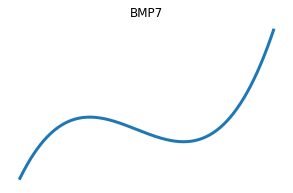

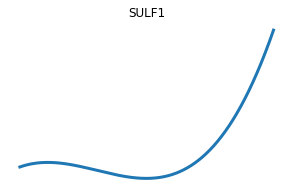

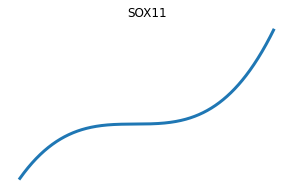

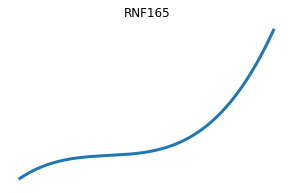

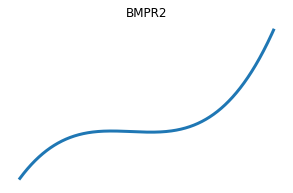

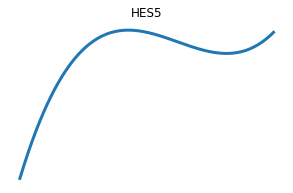

In [36]:
BMP_genes=['BMP7','SULF1','SOX11','RNF165','BMPR2','HES5']
for gene in BMP_genes:
    x=data['pseudotime']
    y=data[gene]
    y=y[numpy.argsort(x)]
    x=sorted(x)
    spl = UnivariateSpline(x, y,k=3)
    xs = np.linspace(0, 1, 1000)
    fig,ax=plt.subplots(figsize=(5,3))
    ax.plot(xs, spl(xs), lw=3)
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(False)
    plt.title(gene)

<AxesSubplot:title={'center':'Mean'}, xlabel='Clusters'>

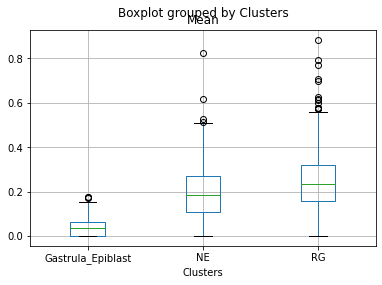

In [37]:
BMP_genes=['BMP7','SULF1','SOX11','RNF165','BMPR2','HES5']

df=pd.DataFrame(np.array(adata_eb_ne_rg[:,BMP_genes].X.mean(axis=1)))

df['cluster']=adata_eb_ne_rg.obs['cluster_id_v1'].values

df.columns=['Mean','Clusters']

df.boxplot('Mean',by='Clusters')
# plt.savefig("/datb/home/wanglab13/PythonScripts/Cell_response/Paper_figures/Boxplot_bmp.pdf", dpi=300, format='pdf', bbox_inches='tight')

## WNT signal pathway

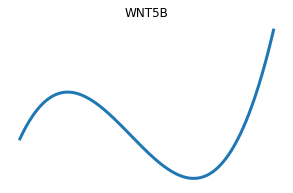

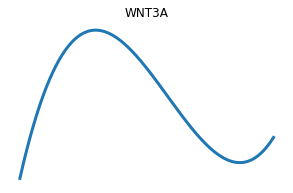

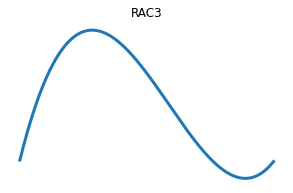

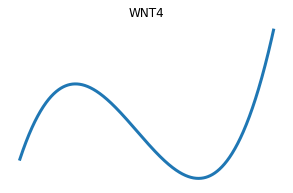

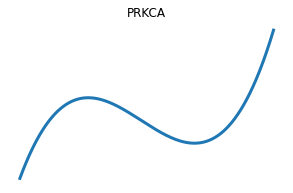

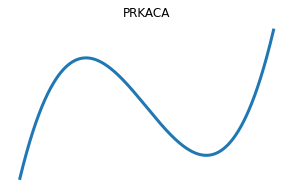

In [38]:
WNT_genes=['WNT5B','WNT3A','RAC3','WNT4','PRKCA','PRKACA']
for gene in WNT_genes:
    x=data['pseudotime']
    y=data[gene]
    y=y[numpy.argsort(x)]
    x=sorted(x)
    spl = UnivariateSpline(x, y,k=3)
    xs = np.linspace(0, 1, 1000)
    fig,ax=plt.subplots(figsize=(5,3))
    ax.plot(xs, spl(xs), lw=3)
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(False)
    plt.title(gene)

<AxesSubplot:title={'center':'Mean'}, xlabel='Clusters'>

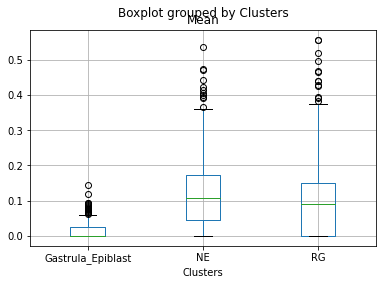

In [39]:
WNT_genes=['WNT5B','WNT3A','RAC3','WNT4','PRKCA','PRKACA']

df=pd.DataFrame(np.array(adata_eb_ne_rg[:,WNT_genes].X.mean(axis=1)))

df['cluster']=adata_eb_ne_rg.obs['cluster_id_v1'].values

df.columns=['Mean','Clusters']

df.boxplot('Mean',by='Clusters')
# plt.savefig("/datb/home/wanglab13/PythonScripts/Cell_response/Paper_figures/Boxplot_wnt.pdf", dpi=300, format='pdf', bbox_inches='tight')

In [42]:
import scipy
from scipy import stats
x=df[df['Clusters']=='Gastrula_Epiblast']['Mean'].values
y=df[df['Clusters']=='NE']['Mean'].values
z=df[df['Clusters']=='RG']['Mean'].values
scipy.stats.ttest_ind(list(x),list(y))
# scipy.stats.ttest_ind(list(x),list(z))

Ttest_indResult(statistic=-11.216875454829692, pvalue=4.7212995370865255e-26)